<a href="https://colab.research.google.com/github/matpaolacci/masked-lm-for-audio/blob/main/masked_audio_lm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configurations

## Set the paths

In [ ]:
import os, sys

# Paths
DATASET_HOME_DIR = '/content/drive/MyDrive/DLProj/Dataset'
RAW_DATASET_DIR = os.path.join(DATASET_HOME_DIR, "OriginalVersion")        # the Slackh2100 dataset
WAV_DATASET_DIR = os.path.join(DATASET_HOME_DIR, "WavVersion")             # the Slackh2100 dataset with .wav stems
UTILITIES_DIR = '/content/drive/MyDrive/DLProj/Utilities'
CHECKPOINTS_DIR = '/content/drive/MyDrive/DLProj/Checkpoints'

sys.path.append(UTILITIES_DIR)

## Set Configuration variables

In [ ]:
# @title  {"display-mode":"form"}
PREPARE_DATASET = False # @param {"type":"boolean"}

In [ ]:
# @title Choose if you want to continue to train a pre-saved model and if you want continue the training or only evaluate it {"form-width":"30%","display-mode":"form"}
EVALUATE_OR_TRAIN = "Evaluate model" # @param ["Start new training", "Evaluate model","Continue training"]
CHECKPOINT_DIRECTORY_NAME = "2024-09-17_112711_BEST" # @param {"type":"string","placeholder":"Enter the directory name 'YYYY-MM-DD_HHMMSS'"}
MODEL_EPOCH_LABEL = 4852 # @param {"type":"integer"}
PRE_SAVED_MODEL_TYPE = "BEST_RECON_ERR" # @param ["BEST_RECON_ERR","BEST_PERPLX","BOTH_PERPLX_RECON_ERR"]
EPOCHS_RE_TRAIN = 3000 # @param {"type":"integer","placeholder":"Enter the number of epochs for training"}

# Set following fields only if previous variable has been set to True
model_checkpoints_dir = os.path.join(CHECKPOINTS_DIR, CHECKPOINT_DIRECTORY_NAME)
PATH_TO_PRE_SAVED_MODEL = os.path.join(model_checkpoints_dir, f'VQVAE_{MODEL_EPOCH_LABEL}_{PRE_SAVED_MODEL_TYPE}')
PATH_TO_HYPERPARAMETERS = os.path.join(model_checkpoints_dir, 'hyper_params.json')

USE_PRE_SAVED_MODEL = True if EVALUATE_OR_TRAIN == "Continue training" else False
ONLY_EVALUATION = True if EVALUATE_OR_TRAIN == "Evaluate model" else False
assert (not USE_PRE_SAVED_MODEL) or (not ONLY_EVALUATION), "If you want do only evaluation then uncheck 'USE_PRE_SAVED_MODEL'"

EVAL_CHECKPOINT_DIR = os.path.join(CHECKPOINTS_DIR, CHECKPOINT_DIRECTORY_NAME)
PATH_TO_MODEL_TO_EVALUATE = os.path.join(EVAL_CHECKPOINT_DIR, f'VQVAE_{MODEL_EPOCH_LABEL}_{PRE_SAVED_MODEL_TYPE}')
PATH_TO_HYPERPARAMETERS_EVALUATION = os.path.join(EVAL_CHECKPOINT_DIR, 'hyper_params.json')

## Import python libraries

In [ ]:
# Install the required python packages
!pip install -r $UTILITIES_DIR/requirements.txt

import zipfile, yaml
import flacconverter as fc
from enum import Enum
from tqdm import tqdm
from datetime import datetime, timedelta
import gc
import json

import torch, torchaudio, pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

# For getting data structure from list
import ast

# Libraries for plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# To plot the graphs of loss and perplexity
from scipy.signal import savgol_filter
from matplotlib.ticker import MaxNLocator

## Create checkpoints directory
It will be created a directory for each training, each one will contain the best trained model across the epochs and a file containing the used hyper parameters.

In [ ]:
datetime_start = (datetime.now() + timedelta(hours=2)).strftime("%Y-%m-%d_%H%M%S")
CURR_CHECKPOINT_DIR = os.path.join(CHECKPOINTS_DIR, datetime_start)
if not ONLY_EVALUATION:
    os.makedirs(CURR_CHECKPOINT_DIR, exist_ok=True)

## Set log file and log function

In [ ]:
LOG_FILE_PATH = os.path.join(CURR_CHECKPOINT_DIR, 'training.log')

def log(message: str):
    if ONLY_EVALUATION:
        return

    with open(LOG_FILE_PATH, "a") as log_file:
        now = datetime.now()
        now_local = now + timedelta(hours=2)
        log_file.write(f'[{now_local.strftime("%Y-%m-%d %H:%M:%S")}] - {message}\n')

# Prepare the data
In this section we are going to download the Slakh2100 dataset available [here](http://www.slakh.com/)

In [ ]:
class Instrument(Enum):
    BASS = 'Bass'
    BRASS = 'Brass'
    CHROMATIC_PERCUSSION = 'Chromatic Percussion'
    DRUMS = 'Drums'
    ETHNIC = 'Ethnic'
    GUITAR = 'Guitar'
    ORGAN = 'Organ'
    PERCUSSIVE = 'Percussive'
    PIANO = 'Piano'
    PIPE = 'Pipe'
    REED = 'Reed'
    SOUND_EFFECTS = 'Sound Effects'
    STRINGS = 'Strings'
    STRINGS_CONTINUED = 'Strings (continued)'
    SYNTH_LEAD = 'Synth Lead'
    SYNTH_PAD = 'Synth Pad'

def extractZipDataset():
    os.makedirs(RAW_DATASET_DIR, exist_ok=False)

    with zipfile.ZipFile(os.path.join(DATASET_HOME_DIR, 'dataset.zip'), 'r') as zipRef:
        zipRef.extractall(RAW_DATASET_DIR)

    print(f'File estratti in {RAW_DATASET_DIR}')

def convertToWav(baseDir: str, outDir: str):
    fc.to_wav(baseDir, outDir, n_threads=2)

def createDatasetForVqVae(instruments_set: set[str], split_sets = ['train', 'test', 'validation']):
    """Questa funzione deve generare un file csv contenente i path, uno per riga, delle tracce audio composte
    dagli strumenti nell'instrumentSet.
    """

    for set_dir in split_sets:
        csv_stems_file_path = os.path.join(DATASET_HOME_DIR, set_dir + "_stems.csv")
        csv_mixes_file_path = os.path.join(DATASET_HOME_DIR, set_dir + "_mixes.csv")

        if os.path.exists(csv_stems_file_path):
            print(f"The file \'{csv_stems_file_path}\' already exists! Are you sure you want overwrite it?")
            continue

        elif os.path.exists(csv_mixes_file_path):
            print(f"The file \'{csv_mixes_file_path}\' already exists! Are you sure you want overwrite it?")
            continue

        else:
            # Adding the table header to the csv for stems
            with open(csv_stems_file_path, 'w') as csv_stems_file:
                csv_stems_file.write("file_path;instrument_class;midi_program;track_name\n")

            # Adding the table header to the csv for mixes
            with open(csv_mixes_file_path, 'w') as csv_mixes_file:
                csv_mixes_file.write("file_path;midi_programs;instruments_classes;track_name\n")

            # Just creating the label to be added to tqdm
            tqdm_description = f"Creating {os.path.basename(csv_stems_file_path)} and {os.path.basename(csv_mixes_file_path)} files"

            # Here we keep track of the file doesn't exist
            not_existing_stems = []

            for track_dir_name in tqdm(os.listdir(os.path.join(WAV_DATASET_DIR, set_dir)), desc=tqdm_description):
                if not os.path.isdir(os.path.join(WAV_DATASET_DIR, set_dir, track_dir_name)):
                    continue

                # Compose the path to the directory of the track
                track_dir_path = os.path.join(WAV_DATASET_DIR, set_dir, track_dir_name)

                with open(os.path.join(track_dir_path, "metadata.yaml"), 'r') as file:
                    yamldata = yaml.safe_load(file)

                    # The list of the midi programs that composed the track
                    midi_programs_list: list[str] = []

                    # The set of the instrument class (es. guitar, piano) that composed the track
                    #   we need of a set since a track can be composed by several midi programs
                    #   (es. Electic Guitar, Classic Guitar) belonging to the same instrument class
                    instruments_classes_set: set[str] = set()

                    for stem_name in yamldata["stems"]:
                        # get the name of the instruments
                        instr_class: str = yamldata["stems"][stem_name]["inst_class"]
                        midi_program: str = yamldata["stems"][stem_name]["midi_program_name"]
                        midi_programs_list.append(midi_program)
                        instruments_classes_set.add(instr_class)

                        if instr_class in instruments_set:

                            # The path to the stem file
                            stem_file_path = os.path.join(track_dir_path, 'stems', stem_name) + ".wav"

                            # check if the file exists
                            if not os.path.exists(stem_file_path):
                                not_existing_stems.append(stem_file_path)
                                continue

                            # add the path to the stem of the intrument to the csv
                            entry = f"{stem_file_path};{instr_class};{midi_program};{track_dir_name.lower()}\n"

                            with open(csv_stems_file_path, 'a') as csv_stems_file:
                                csv_stems_file.write(entry)

                    mixes_file_path = os.path.join(track_dir_path, 'mix.wav')

                    if not os.path.exists(mixes_file_path):
                        not_existing_stems.append(mixes_file_path)
                        continue

                    with open(csv_mixes_file_path, 'a') as csv_mixes_file:
                        entry = f"{mixes_file_path};{midi_programs_list};{list(instruments_classes_set)};{track_dir_name}\n"
                        csv_mixes_file.write(entry)

            # Print the errors
            print(f"The following files don't exist in the {set_dir} set:")
            for err in not_existing_stems:
                print(f"{' ' * 4}{err}")


def prepareDataset():
    extractZipDataset()

    # Convert each set to wav
    for dir in ['train', 'test', 'validation']:
        convertToWav(os.path.join(RAW_DATASET_DIR, dir), os.path.join(WAV_DATASET_DIR, dir))

    createDatasetForVqVae({Instrument.BASS.value, Instrument.PIANO.value, Instrument.DRUMS.value, Instrument.GUITAR.value})

    print("Dataset is ready!")

# Look at the data


## Composition of the train set

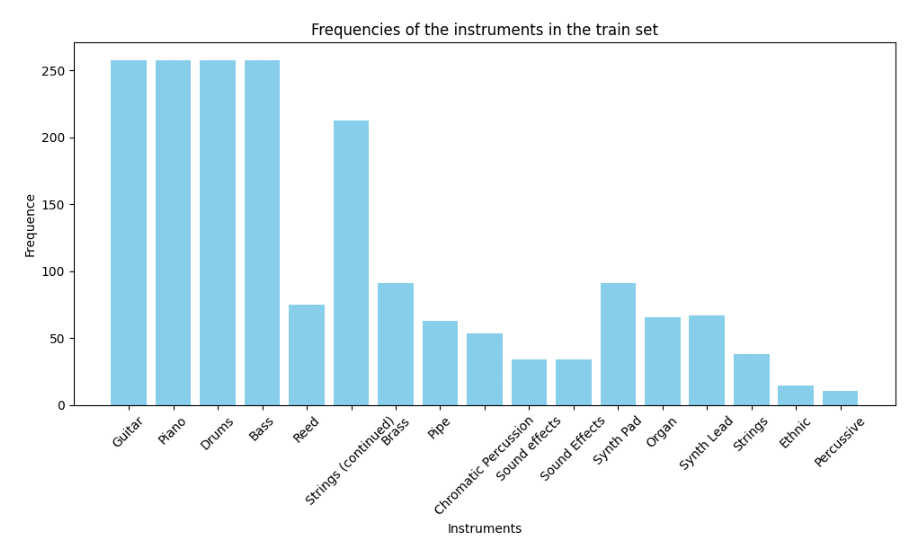

In [ ]:
FIG_SIZE = (15, 7)

pathToHistogramTrain = os.path.join(RAW_DATASET_DIR, "histograms/train.png")
pathToHistogramTest = os.path.join(RAW_DATASET_DIR, "histograms/test.png")
pathToHistogramValidation = os.path.join(RAW_DATASET_DIR, "histograms/validation.png")

trainHist = mpimg.imread(pathToHistogramTrain)
plt.figure(figsize=FIG_SIZE)
plt.imshow(trainHist)
plt.axis('off')
plt.show()

## Let's Plot the graphic of some tracks

In [ ]:
def plot_waveform(waveform, graph_title: str, from_sec:int = None, to_sec: int = None, sample_rate = 44100):

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    # Crea il plot
    plt.figure(figsize=(15, 5))

    for i in range(num_channels):
        plt.plot(time_axis.numpy(), waveform[i].numpy(), label=f'Channel {i+1}')

    # Imposta range di visualizzazione su asse x
    duration_in_sec = num_frames / sample_rate
    plt.xlim(from_sec if from_sec is not None else 0, to_sec if to_sec is not None else duration_in_sec)

    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(graph_title)
    plt.legend()
    plt.show()

# Define the Pytorch datasets

In [ ]:
# The header of the csv are
#   *_stems.csv -> ['file_path', 'instrument_class', 'midi_program', 'track_name']
#   *_mixes.csv -> ['file_path', 'midi_programs', 'instruments_classes', 'track_name']

#TODO: da sistemare
SAMPLE_RATE = 44100 #Hz

def get_alert_message(path, audio_length):
    return f"The file \"{path}\" is shorter than {audio_length}sec"

class StemsDataset(Dataset):
    def __init__(self, csv_audio_path, audio_length, custom_size=None, batch_size=None, transform=None):
        self.audio_csv = pd.read_csv(csv_audio_path, delimiter=';')
        if(custom_size != None):
            sample_size = max(1, min(len(self.audio_csv), custom_size))
            self.audio_csv = self.audio_csv.sample(n=sample_size, random_state=1)

        self.audio_length = audio_length
        self.transform = transform

        # In this way we ensure the last batch have the right size
        if(batch_size is not None):
            assert batch_size <= len(self.audio_csv)
            self.audio_csv = self.audio_csv.head(len(self.audio_csv) - (len(self.audio_csv) % batch_size))

    def __len__(self):
        return len(self.audio_csv)

    def __getitem__(self, idx):
        audio_path = self.audio_csv.iloc[idx, 0]
        waveform, sample_rate = torchaudio.load(audio_path)
        instrument_class = self.audio_csv.iloc[idx, 1]
        midi_program = self.audio_csv.iloc[idx, 2]

        assert waveform.shape[1] >= SAMPLE_RATE * self.audio_length, get_alert_message(audio_path, self.audio_length)

        if self.transform:
            waveform = self.transform(waveform)

        assert waveform.shape[1]/SAMPLE_RATE >= self.audio_length, f"The transformed audio is too short ({waveform.shape[1]/SAMPLE_RATE}sec)!"

        # take the first audio_length seconds
        waveform = waveform[:,0: SAMPLE_RATE * self.audio_length]

        return waveform

In [ ]:
class MixesDataset(Dataset):
    def __init__(self, csv_audio_path, audio_length, custom_size=None, batch_size=None, transform=None):
        self.audio_csv = pd.read_csv(csv_audio_path, delimiter=';')
        if(custom_size != None):
            sample_size = max(1, min(len(self.audio_csv), custom_size))
            self.audio_csv = self.audio_csv.sample(n=sample_size, random_state=1)

        self.audio_length = audio_length
        self.transform = transform

        # In this way we ensure the last batch have the right size
        if(batch_size is not None):
            assert batch_size <= len(self.audio_csv)
            self.audio_csv = self.audio_csv.head(len(self.audio_csv) - (len(self.audio_csv) % batch_size))

    def __len__(self):
        return len(self.audio_csv)

    def __getitem__(self, idx):
        audio_path = self.audio_csv.iloc[idx, 0]
        waveform, sample_rate = torchaudio.load(audio_path)
        midi_programs = ast.literal_eval(self.audio_csv.iloc[idx, 1])
        instruments_class = ast.literal_eval(self.audio_csv.iloc[idx, 2])
        track_name = self.audio_csv.iloc[idx, 3]

        assert waveform.shape[1] >= SAMPLE_RATE * self.audio_length, get_alert_message(audio_path, self.audio_length)

        if self.transform:
            waveform = self.transform(waveform)

        assert waveform.shape[1]/SAMPLE_RATE >= self.audio_length, f"The transformed audio is too short ({waveform.shape[1]/SAMPLE_RATE}sec)!"

        # take the first audio_length seconds
        waveform = waveform[:,0: SAMPLE_RATE * self.audio_length]

        return waveform

In [ ]:
class SingleTrackTestDataset(Dataset):
    def __init__(self, csv_audio_path, index_of_the_track, model_input_length, model_batch_size):
        audio_csv = pd.read_csv(csv_audio_path, delimiter=';')

        assert len(audio_csv) > index_of_the_track, f"The provided index {{{index_of_the_track}}} is greater than the number of tracks in the dataset {{{len(self.audio_csv)}}}!"

        audio_path = audio_csv.iloc[index_of_the_track, 0]
        waveform, sample_rate = torchaudio.load(audio_path)

        self.track_name = audio_csv.iloc[index_of_the_track, 3]

        # Calculate the padding for the track so that we can create the batches to feed the model
        chunk_length = SAMPLE_RATE * model_input_length * model_batch_size
        remainder = waveform.shape[1] % chunk_length
        self.padding_elements_to_add_to_end = chunk_length - remainder

        # resize the waveform to adapt it to the audio_lenght set for the model and batch_size for the model
        waveform = torch.nn.functional.pad(waveform, (0, self.padding_elements_to_add_to_end))
        n_waveforms = waveform.shape[1]//(SAMPLE_RATE * model_input_length)

        # It contains n (divisible by batch_size) chunk of the selected track
        self.single_track_dataset = waveform.view(n_waveforms, (SAMPLE_RATE * model_input_length))

    def __len__(self):
        return self.single_track_dataset.shape[0]

    def __getitem__(self, idx):
        return self.single_track_dataset[idx].unsqueeze(0)

# VQ-VAE: The model architecture

## The Vector Quantizer module
We calculate the loss by summing up two terms:
- **codebook loss**, which moves the embedding towards the encoder output;
- **commitment loss**, which makes sure the encoder commits to an embedding;

In [ ]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        self._commitment_cost = commitment_cost

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim) # TODO: Verifica con float64
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)

    def forward(self, inputs):
        # convert inputs from BCW -> BWC
        inputs = inputs.permute(0, 2, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # # Calculate L2-normalized distance between the inputs and the codes
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)                  # a^2
                    + torch.sum(self._embedding.weight.t()**2, dim=0, keepdim=True) # b^2
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))     # -2ab

        # Get the index of the neareast code (from codebook) for each embeddings output by encoder
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)

        # Quantize and unflatten
        quantized = self._embedding(encoding_indices).view(input_shape)

        # Calculating commitment loss and codebook loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs) # commitment loss
        q_latent_loss = F.mse_loss(quantized, inputs.detach()) # codebook loss
        loss = q_latent_loss + self._commitment_cost * e_latent_loss

        # Straight-through estimator trick for gradient backpropagation
        quantized = inputs + (quantized - inputs).detach()

        # Create a one-hot matrix where the ones at (i, j) position
        #   indicates that the j-th code, from codebook, it was selected
        #   for the i-th embedding vector output by the encoder.
        one_hot_enc = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        one_hot_enc.scatter_(1, encoding_indices, 1)

        # Calculates the average probability of the utilization of each code from codebook
        avg_probs = torch.mean(one_hot_enc, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BWC -> BCHW
        return loss, quantized.permute(0, 2, 1).contiguous(), perplexity, quantized, encoding_indices


In [ ]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        self._commitment_cost = commitment_cost
        self._decay = decay
        self._epsilon = epsilon

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim) # TODO: Verifica con float64
        self._embedding.weight.data.normal_()

        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()

    def forward(self, inputs):
        # convert inputs from BCW -> BWC
        inputs = inputs.permute(0, 2, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # # Calculate L2-normalized distance between the inputs and the codes
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)                  # a^2
                    + torch.sum(self._embedding.weight.t()**2, dim=0, keepdim=True) # b^2
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))     # -2ab

        # Get the index of the neareast code (from codebook) for each embeddings output by encoder
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)

        # Quantize and unflatten
        quantized = self._embedding(encoding_indices).view(input_shape)

        # Create a one-hot matrix where the ones at (i, j) position
        #   indicates that the j-th code, from codebook, was selected
        #   for the i-th embedding vector outputed by the encoder.
        one_hot_enc = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        one_hot_enc.scatter_(1, encoding_indices, 1)

        # Use EMA to update the embedding vectors (codebook)
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(one_hot_enc, 0)

            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)

            dw = torch.matmul(one_hot_enc.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)

            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))

        # Calculating commitment loss and codebook loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs) # commitment loss
        loss = self._commitment_cost * e_latent_loss

        # Straight-through estimator trick for gradient backpropagation
        quantized = inputs + (quantized - inputs).detach()

        # Calculates the average probability of the utilization of each code from codebook
        avg_probs = torch.mean(one_hot_enc, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BWC -> BCHW
        return loss, quantized.permute(0, 2, 1).contiguous(), perplexity, quantized, encoding_indices

## The ResNet module

In [ ]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()

        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv1d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv1d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )

    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()

        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

## Function for initializing convolutional layers

In [ ]:
from math import log2

def get_levels(encoder_output_embeddings, num_layers, reverse=False, model_input_sequence_length=None, padding=1, kernel_size=4, stride=2):
    '''This function returns a list of 2-ple ((input_channels, output_channels), out_padding_boolean)
    within which the first element is a 2-ple representing the input and output dimensions of each encoder/decoder block;
    whereas the second element is a boolean which indicates whether or not the output_padding should be added in the
    decoded layer which it refers.
    Each two subsequent layer it will be a halving/doubling of the dimensionality of the output channels.

    For example, for encoder_output_embeddings=128 and num_layers=4 and model_input_sequence_length=132
    it will return:
            ( (1, 16),   False )
            ( (16, 32),  False )
            ( (32, 64),  True )
            ( (64, 128), False )
    '''
    input_hiddens = []
    output_hiddens = []
    output_padding = []

    assert log2(encoder_output_embeddings) - (int(log2(encoder_output_embeddings))) == 0
    assert log2(encoder_output_embeddings) >= num_layers
    assert model_input_sequence_length is None or model_input_sequence_length >= encoder_output_embeddings

    # assert if reverse=True than model_input_sequence_length must be provided
    assert (not reverse) or model_input_sequence_length is not None

    while(encoder_output_embeddings>=2 and num_layers>0):
        last = not (encoder_output_embeddings//2>=2 and num_layers-1>0)
        input_hiddens.append(encoder_output_embeddings//2 if not last else 1)
        output_hiddens.append(encoder_output_embeddings)

        # if reverse then calculates if the padding for transposeConv1d is needed
        if reverse:
            out_sequence_length = \
                (float(model_input_sequence_length + (2 * padding) - (kernel_size - 1) - 1) / stride) + 1
            output_padding.append(out_sequence_length - int(out_sequence_length) != 0)
            model_input_sequence_length = int(out_sequence_length)

        # Update the loop parameters
        encoder_output_embeddings = encoder_output_embeddings//2
        num_layers-=1

    input_hiddens = input_hiddens[::-1 if not reverse else None]
    output_hiddens = output_hiddens[::-1 if not reverse else None]

    output_padding = output_padding[::-1]

    if reverse:
        return zip(output_hiddens, input_hiddens, output_padding)
    else:
        return zip(input_hiddens, output_hiddens)

## The Encoder architecture

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation_function):
        super(EncoderBlock, self).__init__()

        self._activation_function = activation_function
        self._conv = nn.Conv1d( in_channels=in_channels,
                                out_channels=out_channels,
                                kernel_size=4,
                                stride=2,
                                padding=1)

    def forward(self, x):
        x = self._conv(x)
        x = self._activation_function(x)
        return x


class Encoder(nn.Module):
    def __init__(self,
                 in_channels,
                 num_hiddens, # the dimensionality of the embeddings output by the encoder.
                 num_halving_layers,
                 num_residual_layers,
                 num_residual_hiddens):
        '''The encoder takes a in_channels-dimensional embedding sequence of length N as input
        and maps it in a sequence N/"2^num_halving_layers" smaller of embeddings of dimension "num_hiddens".
        '''

        super(Encoder, self).__init__()
        self._block_activation_function = nn.ReLU()

        self._layers = [
            EncoderBlock(in_channels=_in_channels,
                         out_channels=_out_channels,
                         activation_function=nn.Identity() if (_out_channels == num_hiddens) else self._block_activation_function
            )
            for _in_channels, _out_channels in get_levels(num_hiddens, num_halving_layers)
        ] + [
            nn.Conv1d(  in_channels=num_hiddens,
                        out_channels=num_hiddens,
                        kernel_size=3,
                        stride=1,
                        padding=1),

            ResidualStack(  in_channels=num_hiddens,
                            num_hiddens=num_hiddens,
                            num_residual_layers=num_residual_layers,
                            num_residual_hiddens=num_residual_hiddens),
        ]

        self._encoder = nn.Sequential(*self._layers)

    def forward(self, inputs):
        return self._encoder(inputs)

## The Decoder architecture

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation_function, output_padding):
        super(DecoderBlock, self).__init__()

        self._conv = nn.ConvTranspose1d(in_channels=in_channels,
                                        out_channels=out_channels,
                                        kernel_size=4,
                                        stride=2,
                                        padding=1,
                                        output_padding=output_padding)

        self._activation_function = activation_function

    def forward(self, x):
        x = self._conv(x)
        x = self._activation_function(x)
        return x

class Decoder(nn.Module):
    def __init__(self,
                 in_channels,
                 model_input_sequence_length,
                 num_hiddens, # the dimensionality of the embeddings output by the encoder.
                 num_doubling_layer,
                 num_residual_layers,
                 num_residual_hiddens):
        '''The decoder takes a in_channels-dimensional embedding sequence of length N as input
        and maps it in a sequence N*"2^num_doubling_layer" longer of embeddings of dimension "num_hiddens".
        '''
        super(Decoder, self).__init__()

        self._block_activation_function = nn.ReLU()
        self._output_activation_func = nn.Tanh()  # Output values in range [-1, 1]

        self._layers = [
            nn.Conv1d(  in_channels=num_hiddens,
                        out_channels=num_hiddens,
                        kernel_size=3,
                        stride=1,
                        padding=1),

            ResidualStack(in_channels=num_hiddens,
                        num_hiddens=num_hiddens,
                        num_residual_layers=num_residual_layers,
                        num_residual_hiddens=num_residual_hiddens)
        ] + [
            DecoderBlock(in_channels=_in_channels,
                        out_channels=_out_channels,
                        activation_function=nn.Identity() if (_out_channels == 1) else self._block_activation_function,
                        output_padding=1 if _output_padding_needed else 0)

            for _in_channels, _out_channels, _output_padding_needed in \
                get_levels(
                    num_hiddens,
                    num_doubling_layer,
                    reverse=True,
                    model_input_sequence_length=model_input_sequence_length
                )
        ]

        self._decoder = nn.Sequential(*self._layers)

    def forward(self, x):
        x = self._decoder(x)
        return self._output_activation_func(x)

## The VQ-VAE model

In [ ]:
class VQVAE(nn.Module):
    def __init__(self,
                 model_input_sequence_length,
                 num_hiddens, # the dimensionality of the embeddings output by the encoder.
                 num_halving_layers,
                 num_residual_layers,
                 num_residual_hiddens,
                 num_embeddings,
                 embedding_dim,
                 commitment_cost,
                 decay):

        super(VQVAE, self).__init__()

        self._encoder = Encoder(1,
                                num_hiddens,
                                num_halving_layers,
                                num_residual_layers,
                                num_residual_hiddens)

        # It maps the "num_hiddens-dimensional" embedding sequence in a "embedding_dim-dimensional" sequence
        #   preparing it for quantization
        self._pre_vq_conv = nn.Conv1d(in_channels=num_hiddens,
                                      out_channels=embedding_dim,
                                      kernel_size=1,
                                      stride=1)

        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim,
                                               commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                            commitment_cost)

        # It maps the "embedding_dim-dimensional" embedding sequence in a "num_hiddens-dimensional" embeddin sequence
        #   preparing it for the decoding operation (added by me)
        self._post_vq_conv = nn.Conv1d(in_channels=embedding_dim,
                                       out_channels=num_hiddens,
                                       kernel_size=1,
                                       stride=1)

        self._decoder = Decoder(num_hiddens,
                                model_input_sequence_length,
                                num_hiddens,
                                num_halving_layers,
                                num_residual_layers,
                                num_residual_hiddens)

    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, quantized_values, encoding_indices = self._vq_vae(z)
        decoder_input = self._post_vq_conv(quantized)
        x_recon = self._decoder(decoder_input)

        return loss, x_recon, perplexity, quantized_values, encoding_indices

# Training of the VQ-VAE

## Select the device (cpu or gpu)

In [ ]:
# @title
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"You are using {device}!")

You are using cuda!


## Define the hyper parameters

In [ ]:
if USE_PRE_SAVED_MODEL:
    with open(PATH_TO_HYPERPARAMETERS, 'r') as hyper_params_file:
        HYPER_PARAMS = json.load(hyper_params_file)
        HYPER_PARAMS["epochs"] = EPOCHS_RE_TRAIN

elif ONLY_EVALUATION:
    with open(PATH_TO_HYPERPARAMETERS_EVALUATION, 'r') as hyper_params_file:
        HYPER_PARAMS = json.load(hyper_params_file)
else:
    HYPER_PARAMS = {
        "batch_size": 4,
        "epochs": 8000,

        # Dataset settings
        "train_size": 16,
        "validation_size": 4,
        "test_size": 4,

        # Inputs audio track length in seconds
        "audio_length": 14,

        # Control the silence in the track
        "remove_silence": True,

        # Dimensionality of each encoded vector just before quantization
        "num_hiddens": 128,

        # The quantized sequence has length:
        #   ~(audio_length * 44100 / 2^num_halving_layers)
        "num_halving_layers": 4,

        # The ResNet parameters
        "num_residual_hiddens": 64,
        "num_residual_layers": 3,

        # The dimensionality of the space where the codebook lies
        "embedding_dim": 64,

        # Number of the codes in the codebook
        "num_embeddings": 512,

        # To make sure the encoder commits to an embedding
        "commitment_cost": 0.25,
        "decay": 0.99,
        "learning_rate": 0.001,
        "use_spectral": True
    }

# Save the hyper params configuration in the training dir
if not ONLY_EVALUATION:
    with open(os.path.join(CURR_CHECKPOINT_DIR, "hyper_params.json"), 'w') as hyp_params_file:
        json.dump(HYPER_PARAMS, hyp_params_file, indent=4)

## Create the Datasets

### Define dataset transformation function

In [ ]:
def trim_silence(waveform: torch.Tensor):
    return waveform[waveform != 0].unsqueeze(0)

### Build the Pytorch dataset object

In [ ]:
# @title Select what dataset you want to use {"form-width":"20%","display-mode":"form"}
USE_STEMS = False # @param {"type":"boolean"}
if USE_STEMS:
    train_csv_path = os.path.join(DATASET_HOME_DIR, "train_stems.csv")
    test_csv_path = os.path.join(DATASET_HOME_DIR, "test_stems.csv")
    validation_csv_path = os.path.join(DATASET_HOME_DIR, "validation_stems.csv")

    train_set = StemsDataset(
                    train_csv_path,
                    HYPER_PARAMS['audio_length'],
                    batch_size=HYPER_PARAMS['batch_size'],
                    transform=trim_silence if HYPER_PARAMS['remove_silence'] else None
    )
    test_set = StemsDataset(
                    test_csv_path,
                    HYPER_PARAMS['audio_length'],
    )
    validation_set = StemsDataset(
                    validation_csv_path,
                    HYPER_PARAMS['audio_length'],
                    batch_size=HYPER_PARAMS['batch_size']
    )
else:
    train_csv_path = os.path.join(DATASET_HOME_DIR, "train_mixes.csv")
    test_csv_path = os.path.join(DATASET_HOME_DIR, "test_mixes.csv")
    validation_csv_path = os.path.join(DATASET_HOME_DIR, "validation_mixes.csv")

    train_set = MixesDataset(
                    train_csv_path,
                    HYPER_PARAMS['audio_length'],
                    custom_size=HYPER_PARAMS['train_size'],
                    transform=trim_silence if HYPER_PARAMS['remove_silence'] else None # It was set later than the best training
    )
    test_set = MixesDataset(
                    test_csv_path,
                    HYPER_PARAMS['audio_length']
    )
    validation_set = MixesDataset(
                    validation_csv_path,
                    HYPER_PARAMS['audio_length'],
                    custom_size=HYPER_PARAMS['validation_size']
    )

train_csv_entries = !wc -l $train_csv_path
train_csv_entries = int(train_csv_entries[0].split()[0])
test_csv_entries = !wc -l $test_csv_path
test_csv_entries = int(test_csv_entries[0].split()[0])
validation_csv_entries = !wc -l $validation_csv_path
validation_csv_entries = int(validation_csv_entries[0].split()[0])

print(f"------- Original datasets statistics -------\n")
print(f"The train csv file has {{{train_csv_entries}}} entries.")
print(f"The test csv file has {{{test_csv_entries}}} entries.")
print(f"The validation csv file has {{{validation_csv_entries}}}.")

print(f"\n\n------- Built datasets statistics -------\n")
print(f"Train set has {{{len(train_set)}}} entries.")
print(f"Test set has {{{len(test_set)}}} entries.")
print(f"Validation set has {{{len(validation_set)}}} entries.")

------- Original datasets statistics -------

The train csv file has {258} entries.
The test csv file has {32} entries.
The validation csv file has {55}.


------- Built datasets statistics -------

Train set has {16} entries.
Test set has {31} entries.
Validation set has {4} entries.


## Create the Dataloaders

In [ ]:
train_vqvae_dataloader = DataLoader(train_set, batch_size=HYPER_PARAMS['batch_size'], shuffle=True)
validation_vqvae_dataloader = DataLoader(validation_set, batch_size=HYPER_PARAMS['batch_size'], shuffle=True)
test_vqvae_dataloader = DataLoader(test_set, batch_size=HYPER_PARAMS["batch_size"], shuffle=False)

## Create the model to train
If we set the 'USE_PRE_SAVED_MODEL' to *True* then the selected pre-saved model will be train, else a new one will be created.

In [ ]:
if not ONLY_EVALUATION:
    # define the model
    vqvae_model = VQVAE(
        HYPER_PARAMS["audio_length"] * SAMPLE_RATE,
        HYPER_PARAMS["num_hiddens"],
        HYPER_PARAMS["num_halving_layers"],
        HYPER_PARAMS["num_residual_layers"],
        HYPER_PARAMS["num_residual_hiddens"],
        HYPER_PARAMS["num_embeddings"],
        HYPER_PARAMS["embedding_dim"],
        HYPER_PARAMS["commitment_cost"],
        HYPER_PARAMS["decay"]
    ).to(device)

    if USE_PRE_SAVED_MODEL:
        vqvae_model.load_state_dict(
            torch.load(PATH_TO_PRE_SAVED_MODEL, map_location=torch.device('cuda'))
        )

    optimizer = optim.Adam(vqvae_model.parameters(), lr=HYPER_PARAMS['learning_rate'], amsgrad=False)

## Pretty print of the Encoder and Decoder configuration

In [ ]:
# @title
from prettytable import PrettyTable

model_input_sequence_length = SAMPLE_RATE*HYPER_PARAMS["audio_length"]

# calculates output sequence length from convolution
conv_out_sequence_len = lambda in_dim: int((float(id_dim + (2 * 1) - (4 - 1) - 1) / 2) + 1)

conv_layers = HYPER_PARAMS["num_halving_layers"]
lay_i=1
encoder_output_embeddings = HYPER_PARAMS["num_hiddens"]

print(f"\nInfo: The sequence output by the Encoder is {2**conv_layers} times shorter than the input sequence to the model.\n")
print("+--------------------- Display Encoder layers setting ---------------------+\n")

enc_table = PrettyTable()
enc_table.field_names = ["input_embeddings", "out_embeddings", "out_sequence_length"]

for i, o in get_levels(encoder_output_embeddings, conv_layers, reverse=False):
    enc_table.add_row((i, o, int(model_input_sequence_length/2**(lay_i))))
    lay_i+=1

print(enc_table)

print("\n\n+--------------------- Display Decoder layers setting ---------------------+\n")

dec_table = PrettyTable()
dec_table.field_names = ["input_embeddings", "out_embeddings", "output_padding", "out_sequence_length"]

lay_i=0 #reset
for i, o, pad in get_levels(encoder_output_embeddings, conv_layers, reverse=True, model_input_sequence_length=model_input_sequence_length):
    dec_table.add_row((i, o, pad, int(model_input_sequence_length/2**(conv_layers-lay_i))))
    lay_i+=1

print(dec_table)


Info: The sequence output by the Encoder is 16 times shorter than the input sequence to the model.

+--------------------- Display Encoder layers setting ---------------------+

+------------------+----------------+---------------------+
| input_embeddings | out_embeddings | out_sequence_length |
+------------------+----------------+---------------------+
|        1         |       16       |        308700       |
|        16        |       32       |        154350       |
|        32        |       64       |        77175        |
|        64        |      128       |        38587        |
+------------------+----------------+---------------------+


+--------------------- Display Decoder layers setting ---------------------+

+------------------+----------------+----------------+---------------------+
| input_embeddings | out_embeddings | output_padding | out_sequence_length |
+------------------+----------------+----------------+---------------------+
|       128        |       64 

## Define the Spectral Loss

In [ ]:
def compute_stft_magnitude(x):
    stft_x = torch.stft(x, n_fft=1024, hop_length=256, win_length=1024, window=torch.hann_window(1024, device=device), return_complex=True)
    return torch.abs(stft_x)

def spectral_loss(x_original, x_reconstructed):
    '''Compute the magnitude of the STFT for both signals'''
    mag_x_original = compute_stft_magnitude(x_original.squeeze(1)).unsqueeze(1)
    mag_x_reconstructed = compute_stft_magnitude(x_reconstructed.squeeze(1)).unsqueeze(1)

    # Return the loss as L2 between signals
    return F.mse_loss(mag_x_original, mag_x_reconstructed)

## Define a function that plots training statistics

In [ ]:
def plot_loss_and_perplexity(train_res_recon_error, train_perplexity, valid_recon_error, valid_perplexity):
    WINDOW_LENGTH = 201

    # Create a figure with a 2x2 grid of graphs
    f = plt.figure(figsize=(16, 12))

    # Graph 1: NMSE train
    ax = f.add_subplot(2, 2, 1)
    ax.plot(savgol_filter(train_res_recon_error, WINDOW_LENGTH, 7))
    ax.set_yscale('log')
    ax.set_title('Smoothed NMSE (Train)')
    ax.set_xlabel('epochs')

    # Graph 2: Perplexity train
    ax = f.add_subplot(2, 2, 2)
    ax.plot(savgol_filter(train_perplexity, WINDOW_LENGTH, 7))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=10))
    ax.set_title('Train Smoothed Average codebook usage (Perplexity)')
    ax.set_xlabel('epochs')

    # Graph 3: NMSE validation
    ax = f.add_subplot(2, 2, 3)
    ax.plot(savgol_filter(valid_recon_error, WINDOW_LENGTH, 7))
    ax.set_yscale('log')
    ax.set_title('Smoothed NMSE (Validation)')
    ax.set_xlabel('epochs')

    # Graph 4: Perplexity validation
    ax = f.add_subplot(2, 2, 4)
    ax.plot(savgol_filter(valid_perplexity, WINDOW_LENGTH, 7))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=10))
    ax.set_title('Validation Smoothed Average codebook usage (Perplexity)')
    ax.set_xlabel('epochs')

    f.savefig(os.path.join(CURR_CHECKPOINT_DIR, "train_statistics.png"))

## Define a per-epoch training function

In [ ]:
# @title
def train_one_epoch(train_dataloader: DataLoader, epoch_index):

    train_res_recon_error = []
    train_res_perplexity = []

    for _, inputs in enumerate(train_dataloader):

        inputs = inputs.to(device)

        data_variance = torch.var(inputs, correction=0)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        vq_loss, data_recon, perplexity, _, _ = vqvae_model(inputs)

        # Compute the losses and its gradients
        recon_error = F.mse_loss(data_recon, inputs) / data_variance

        if HYPER_PARAMS["use_spectral"]:
            # Compute the Spectral Loss
            spectral_loss_value = spectral_loss(inputs, data_recon)
        else:
            spectral_loss_value = 0

        #vq_loss = vq_loss / data_variance
        loss = recon_error + vq_loss + spectral_loss_value
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        train_res_recon_error.append(recon_error.item())
        train_res_perplexity.append(perplexity.item())

    return np.mean(train_res_recon_error), np.mean(train_res_perplexity)

## Define the main training function

In [ ]:
KEEP_LAST_N_MODELS = 1
THRESHOLD_ERROR_TO_SAVE_MODEL = 0.9

def training_loop():

    epoch_number = 1

    best_valid_recon_error = 1_000_000
    best_valid_perplexity = 1

    # To keep track of the saved models
    saved_models = {
        "RECON_ERROR": [],
        "PERPLX": [],
        "BOTH": []
    }

    # To keep track of the loss and perplexity along epochs and finally plot the graphs
    train_recon_error_per_epoch = []
    train_perplexity_per_epoch = []
    valid_recon_error_per_epoch = []
    valid_perplexity_per_epoch = []

    with tqdm(total=HYPER_PARAMS["epochs"]) as pbar:
        for epoch in range(HYPER_PARAMS["epochs"]):
            log('EPOCH {}'.format(epoch_number))

            # Make sure gradient tracking is on, and do a pass over the data
            vqvae_model.train()
            avg_train_recon_error, avg_train_perplexity = train_one_epoch(train_vqvae_dataloader,epoch_number)

            # Store statistics
            train_recon_error_per_epoch.append(avg_train_recon_error)
            train_perplexity_per_epoch.append(avg_train_perplexity)

            # Set the model to evaluation mode, disabling dropout and using population
            # statistics for batch normalization.
            vqvae_model.eval()

            valid_res_recon_error = []
            valid_res_perplexity = []

            # Disable gradient computation and reduce memory consumption.
            with torch.no_grad():
                for i, valid_inputs in enumerate(validation_vqvae_dataloader):
                    valid_inputs = valid_inputs.to(device)
                    data_variance = torch.var(valid_inputs, correction=0)
                    valid_vq_loss, valid_data_recon, valid_perplexity, _, _ = vqvae_model(valid_inputs)
                    recon_error = F.mse_loss(valid_data_recon, valid_inputs) / data_variance
                    valid_res_recon_error.append(recon_error.item())
                    valid_res_perplexity.append(valid_perplexity.item())

            avg_valid_recon_error = np.mean(valid_res_recon_error)
            avg_valid_perplexity = np.mean(valid_res_perplexity)

            # Store statistics
            valid_recon_error_per_epoch.append(avg_valid_recon_error)
            valid_perplexity_per_epoch.append(avg_valid_perplexity)

            # Log error and perplexity
            log(f"Train reconstruction error: {avg_train_recon_error} - Validation reconstruction error: {avg_valid_recon_error}")
            log(f"Train perplexity: {avg_train_perplexity} - Validation perplexity: {avg_valid_perplexity}")

            pbar.set_postfix({
                'Train reconstruction err': f'{avg_train_recon_error}',
                'Train perplexity': f'{avg_train_perplexity}'
            })

            # Check if the error is lower than set threshold
            if (avg_valid_recon_error < THRESHOLD_ERROR_TO_SAVE_MODEL):

                if (avg_valid_recon_error < best_valid_recon_error or
                    avg_valid_perplexity > best_valid_perplexity):

                    select_storage = None

                    if (avg_valid_recon_error < best_valid_recon_error and avg_valid_perplexity > best_valid_perplexity):
                        best_valid_recon_error = avg_valid_recon_error
                        best_valid_perplexity = avg_valid_perplexity
                        model_name = 'VQVAE_{}_BEST_BOTH_PERPLX_RECON_ERR'.format(epoch_number)
                        select_storage = "BOTH"

                    # Save the model because validation reconstruction error is improved
                    elif (avg_valid_recon_error < best_valid_recon_error):
                        best_valid_recon_error = avg_valid_recon_error
                        model_name = 'VQVAE_{}_BEST_RECON_ERR'.format(epoch_number)
                        select_storage = "RECON_ERROR"

                    # Save the model beacause validation perplexity as grown
                    elif (avg_valid_perplexity > best_valid_perplexity):
                        best_valid_perplexity = avg_valid_perplexity
                        model_name = 'VQVAE_{}_BEST_PERPLX'.format(epoch_number)
                        select_storage = "PERPLX"

                    # Save the model
                    model_path = os.path.join(CURR_CHECKPOINT_DIR, model_name)
                    torch.save(vqvae_model.state_dict(), model_path)

                    # Keep track of saved models
                    saved_models[select_storage].append(model_path)

                    # delete too old saved models
                    if len(saved_models[select_storage]) > KEEP_LAST_N_MODELS:
                        os.remove(saved_models[select_storage][0])
                        saved_models[select_storage] = saved_models[select_storage][1:]

            epoch_number += 1
            pbar.update(1)

    plot_loss_and_perplexity(train_recon_error_per_epoch, train_perplexity_per_epoch, valid_recon_error_per_epoch, valid_perplexity_per_epoch)

## Train!

In [ ]:
if not ONLY_EVALUATION:
    training_loop()

# Quantitative Evaluation

In [ ]:
# @title
# If we are only evaluating then we must load a pre-trained model
#   else we use the newly trained model
if ONLY_EVALUATION:
    vqvae_model = VQVAE(
        HYPER_PARAMS["audio_length"] * SAMPLE_RATE,
        HYPER_PARAMS["num_hiddens"],
        HYPER_PARAMS["num_halving_layers"],
        HYPER_PARAMS["num_residual_layers"],
        HYPER_PARAMS["num_residual_hiddens"],
        HYPER_PARAMS["num_embeddings"],
        HYPER_PARAMS["embedding_dim"],
        HYPER_PARAMS["commitment_cost"],
        HYPER_PARAMS["decay"]
    ).to(device)

    vqvae_model.load_state_dict(
        torch.load(
            PATH_TO_MODEL_TO_EVALUATE,
            map_location=torch.device('cuda')
        )
    )

_ = vqvae_model.eval()

<ipython-input-32-1aacd7de0460>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(


In [ ]:
# @title Select the dataset {"run":"auto"}
dataset_to_evaluate_on = test_vqvae_dataloader # @param ["train_vqvae_dataloader","validation_vqvae_dataloader","test_vqvae_dataloader"] {"type":"raw"}
data_iterator = iter(dataset_to_evaluate_on)
batch_number = 1

In [ ]:
# @title Re-run this cell if you want to access the next batch

batch_test_inputs = next(data_iterator).to(device)
print(f"Batch number: {batch_number}")
batch_number += 1
test_vq_loss, test_data_recon, test_perplexity, _, _ = vqvae_model(batch_test_inputs)
batch_data_variance = torch.var(batch_test_inputs, correction=0)
print(f"Test perplexity: {test_perplexity}")
print(f"Test data_variance: {batch_data_variance}")
print(f"Test vq_loss: {test_vq_loss}")
print(f"Test recon_error: {F.mse_loss(test_data_recon, batch_test_inputs) / batch_data_variance}")

Batch number: 1
Test perplexity: 77.8159408569336
Test data_variance: 0.029485465958714485
Test vq_loss: 0.029432564973831177
Test recon_error: 0.0042203799821436405


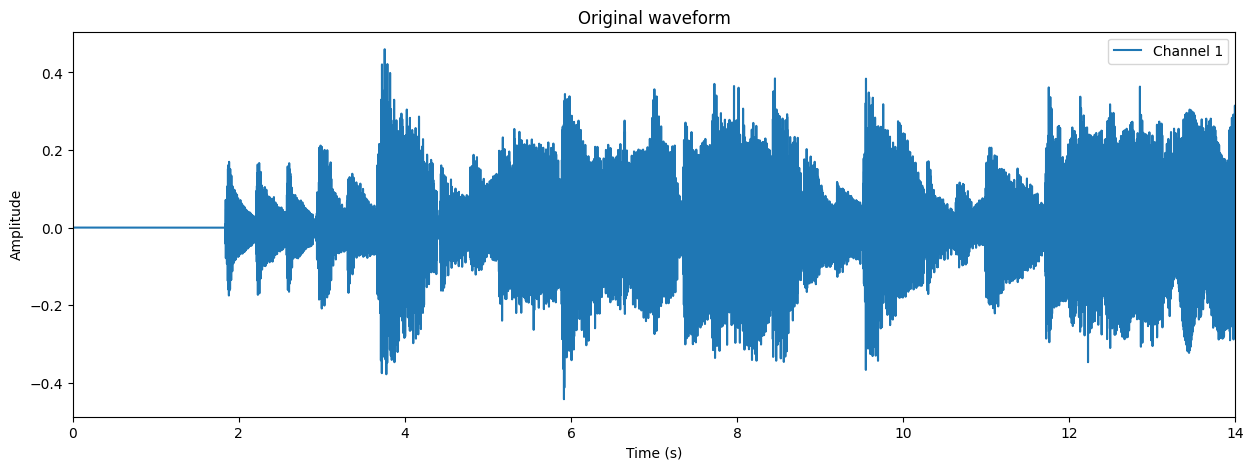

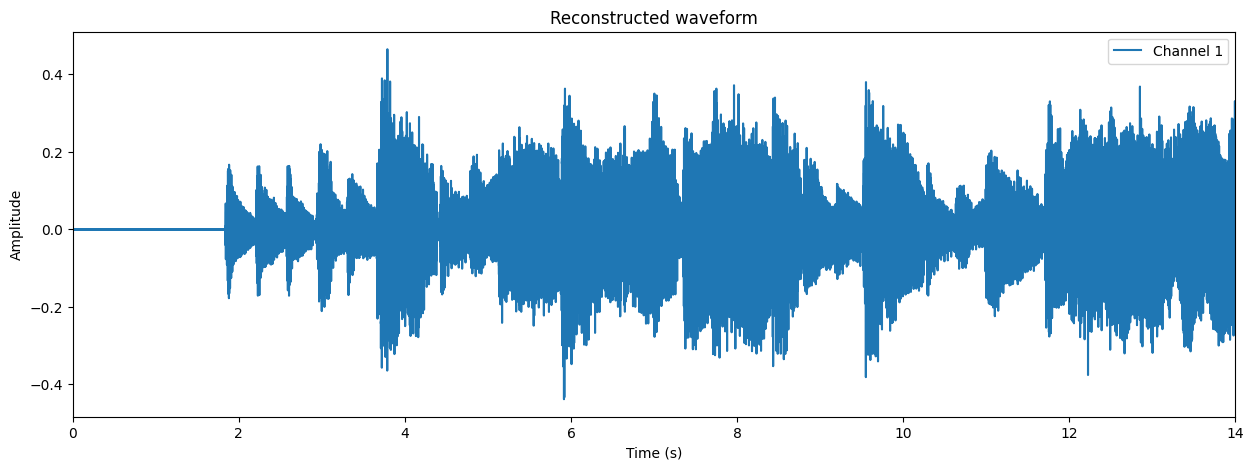

In [ ]:
# @title ## Play with Test data {"run":"auto","vertical-output":true}
num = 1 # @param {"type":"slider","min":0,"max":4,"step":1}
import IPython.display as ipd
import librosa

audio_numpy_v = batch_test_inputs.detach().cpu()[num][0].numpy()
audio_numpy_r = test_data_recon.detach().cpu()[num][0].numpy()

# Usa IPython.display per riprodurre l'audio
ipd.display(ipd.Audio(audio_numpy_v, rate=44100))
ipd.display(ipd.Audio(audio_numpy_r, rate=44100))
plot_waveform(batch_test_inputs.cpu()[num], graph_title="Original waveform")
plot_waveform(test_data_recon.detach().cpu()[num], graph_title="Reconstructed waveform")

In [ ]:
# @title ## Reconstruct entire tracks from Train, Validation or Test set {"form-width":"20%"}

def reconstruct_the_track(dataloader, padding_added_to_the_end: int):
    batch_test_recon_error = []
    batch_test_res_perplexity = []
    reconstructed_track = torch.tensor([]).cpu()

    for input in iter(dataloader):
        input = input.to(device)
        test_vq_loss, test_data_recon, test_perplexity, _, _ = vqvae_model(input)
        batch_data_variance = torch.var(batch_test_inputs, correction=0)
        recon_error = F.mse_loss(test_data_recon, batch_test_inputs) / batch_data_variance
        batch_test_recon_error.append(recon_error.item())
        batch_test_res_perplexity.append(test_perplexity.item())
        reconstructed_track = \
            torch.cat((reconstructed_track, test_data_recon.detach().view(HYPER_PARAMS['batch_size'] * SAMPLE_RATE * HYPER_PARAMS['audio_length']).cpu()), dim=0)

    reconstructed_track = reconstructed_track[:-padding_added_to_the_end].unsqueeze(0).cpu()

    return reconstructed_track, np.mean(batch_test_res_perplexity), np.mean(batch_test_recon_error)


def reconstruct_the_dataset(dataset_csv: str, selected_dataset: str, n_tracks_to_reconstruct: int):
    working_dir = os.path.join(EVAL_CHECKPOINT_DIR, "ReconstrutedTracks", selected_dataset.lower())
    assert not os.path.exists(working_dir), f"The working directory '{working_dir}' already exists!"
    os.makedirs(working_dir, exist_ok=False)

    print(f"Reconstructed audio tracks wirth statistics are saved at '{working_dir}'")

    statistics_file = os.path.join(working_dir, "Statistics.csv")
    assert not os.path.exists(statistics_file), "The Statistics file already exists"

    label_for_recon_error = f"Reconstrucion Error{' (With Spectral loss)' if HYPER_PARAMS['use_spectral'] else None}"
    with open(statistics_file, 'w') as f:
        f.write(f"Track name;{label_for_recon_error};Perplexity;Average {label_for_recon_error};Average Perplexity\n")

    recon_error_along_dataset = []
    perplexity_along_dataset = []

    for track_i in tqdm(range(n_tracks_to_reconstruct)):
        single_track_test_set = SingleTrackTestDataset(
                                    dataset_csv,
                                    track_i,
                                    HYPER_PARAMS['audio_length'],
                                    HYPER_PARAMS['batch_size']
                                )

        single_track_dataloader = DataLoader(
                                    single_track_test_set,
                                    batch_size=HYPER_PARAMS['batch_size'],
                                    shuffle=False
                                )

        reconstructed_track, perplexity, recon_error = reconstruct_the_track(
                                                            single_track_dataloader,
                                                            single_track_test_set.padding_elements_to_add_to_end
                                                    )
        track_name = single_track_test_set.track_name

        # Clean memory
        del single_track_dataloader, single_track_test_set
        torch.cuda.empty_cache()

        # Save the reconstructed track into file
        torchaudio.save(os.path.join(working_dir,f'{track_name}.wav'), reconstructed_track, SAMPLE_RATE)

        # Store statistics
        recon_error_along_dataset.append(recon_error)
        perplexity_along_dataset.append(perplexity)

        with open(statistics_file, 'a') as f:
            f.write(f"{track_name};{recon_error};{perplexity};NaN;NaN\n")

    with open(statistics_file, 'a') as f:
        f.write(f"NaN;NaN;NaN;{np.mean(recon_error_along_dataset)};{np.mean(perplexity_along_dataset)}\n")

# @title  {"form-width":"30%"}
selected_dataset_to_reconstruct = "Train" # @param ["Train","Validation","Test"]
n_tracks_to_reconstruct = 1 # @param {"type":"integer","placeholder":"Insert the number of tracks you want to reconstruct from the selected dataset"}
selected_csv = None

if selected_dataset_to_reconstruct == "Train":
    selected_csv = train_csv_path
    assert n_tracks_to_reconstruct <= len(train_set), "There are not so many data in the Train set"
elif selected_dataset_to_reconstruct == "Validation":
    selected_csv = validation_csv_path
    assert n_tracks_to_reconstruct <= len(validation_set), "There are not so many data in the Train set"
elif selected_dataset_to_reconstruct == "Test":
    selected_csv = test_csv_path
    assert n_tracks_to_reconstruct <= len(test_set), "There are not so many data in the Train set"

reconstruct_the_dataset(selected_csv, selected_dataset_to_reconstruct, n_tracks_to_reconstruct)

Reconstructed audio tracks wirth statistics are saved at '/content/drive/MyDrive/DLProj/Checkpoints/2024-09-17_112711_BEST/ReconstrutedTracks/train'


100%|██████████| 1/1 [00:03<00:00,  3.44s/it]


# Implementing a transformer model: BERT for audio
I used just the BERT model starting from the code provided in the official repo available [here](https://github.com/codertimo/BERT-pytorch/tree/master) adjusting it to accomplish the following tasks in the audio setting:
- **Audio generation**: by feeding the model a track in which only the initial and the end parts are unmasked whereas the "center" is masked, therefore, the model tries to fill the missing part in order to bridge the gap between them.

- **Stem separation**:

## Residual connection and Layer Norm

In [ ]:
class LayerNorm(nn.Module):
    "Construct a layernorm module"

    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2


class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """

    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

## Embedding

In [ ]:
class PositionalEmbedding(nn.Module):

    def __init__(self, d_model, max_len=512):
        """
        :param d_model: embedding dimension in input
        :param max_len: the length of the input sequence
        """
        super().__init__()

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.requires_grad_(False)

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        # select the columns every 2 positions starting from 0 (select even columns)
        pe[:, 0::2] = torch.sin(position * div_term)

        # select the columns every 2 positions starting from 1 (select odd columns)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]

In [ ]:
class BERTEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_size, dropout=0.1):
        """
        :param vocab_size: total vocab size
        :param embed_size: embedding size of token embedding
        :param dropout: dropout rate
        """
        super().__init__()
        self.position = PositionalEmbedding(d_model=embed_size)
        self.dropout = nn.Dropout(p=dropout)
        self.embed_size = embed_size

    def forward(self, sequence):
        x = sequence + self.position(sequence)
        return self.dropout(x)

## Attention

In [ ]:
class Attention(nn.Module):
    """
    Compute 'Scaled Dot Product Attention
    """

    def forward(self, query, key, value, mask=None, dropout=None):
        scores = torch.matmul(query, key.transpose(-2, -1)) \
                 / math.sqrt(query.size(-1))

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        p_attn = F.softmax(scores, dim=-1)

        if dropout is not None:
            p_attn = dropout(p_attn)

        return torch.matmul(p_attn, value), p_attn

In [ ]:
class MultiHeadedAttention(nn.Module):
    """
    Take in model size and number of heads.
    """

    def __init__(self, h, d_model, dropout=0.1):
        super().__init__()
        assert d_model % h == 0

        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h

        self.linear_layers = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(3)])
        self.output_linear = nn.Linear(d_model, d_model)
        self.attention = Attention()

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [l(x).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linear_layers, (query, key, value))]

        # 2) Apply attention on all the projected vectors in batch.
        x, attn = self.attention(query, key, value, mask=mask, dropout=self.dropout)

        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.h * self.d_k)

        return self.output_linear(x)

## The transformer

In [ ]:
class TransformerBlock(nn.Module):
    """
    Bidirectional Encoder = Transformer (self-attention)
    Transformer = MultiHead_Attention + Feed_Forward with sublayer connection
    """

    def __init__(self, hidden, attn_heads, feed_forward_hidden, dropout):
        """
        :param hidden: hidden size of transformer
        :param attn_heads: head sizes of multi-head attention
        :param feed_forward_hidden: feed_forward_hidden, usually 4*hidden_size
        :param dropout: dropout rate
        """

        super().__init__()
        self.attention = MultiHeadedAttention(h=attn_heads, d_model=hidden)
        self.feed_forward = PositionwiseFeedForward(d_model=hidden, d_ff=feed_forward_hidden, dropout=dropout)
        self.input_sublayer = SublayerConnection(size=hidden, dropout=dropout)
        self.output_sublayer = SublayerConnection(size=hidden, dropout=dropout)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, mask):
        x = self.input_sublayer(x, lambda _x: self.attention.forward(_x, _x, _x, mask=mask))
        x = self.output_sublayer(x, self.feed_forward)
        return self.dropout(x)

## BERT

In [ ]:
class BERT(nn.Module):
    """
    BERT model : Bidirectional Encoder Representations from Transformers.
    """

    def __init__(self, vocab_size, hidden=768, n_layers=12, attn_heads=12, dropout=0.1):
        """
        :param vocab_size: vocab_size of total words
        :param hidden: BERT model hidden size
        :param n_layers: numbers of Transformer blocks(layers)
        :param attn_heads: number of attention heads
        :param dropout: dropout rate
        """

        super().__init__()
        self.hidden = hidden
        self.n_layers = n_layers
        self.attn_heads = attn_heads

        # paper noted they used 4*hidden_size for ff_network_hidden_size
        self.feed_forward_hidden = hidden * 4

        # embedding for BERT, sum of positional, segment, token embeddings
        self.embedding = BERTEmbedding(vocab_size=vocab_size, embed_size=hidden)

        # multi-layers transformer blocks, deep network
        self.transformer_blocks = nn.ModuleList(
            [TransformerBlock(hidden, attn_heads, hidden * 4, dropout) for _ in range(n_layers)])

    def forward(self, x):
        # attention masking for padded token
        # torch.ByteTensor([batch_size, 1, seq_len, seq_len)
        mask = (x > 0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1)

        x = self.embedding(x)

        # running over multiple transformer blocks
        for transformer in self.transformer_blocks:
            x = transformer.forward(x, mask)

        return x

## Language model for audio

In [ ]:
class MaskedLanguageModel(nn.Module):
    """
    predicting origin token from masked input sequence
    n-class classification problem, n-class = vocab_size
    """

    def __init__(self, hidden, vocab_size):
        """
        :param hidden: output size of BERT model
        :param vocab_size: total vocab size
        """
        super().__init__()
        self.linear = nn.Linear(hidden, vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        return self.softmax(self.linear(x))

In [ ]:
class BERTLM(nn.Module):
    """
    BERT Language Model
    Next Sentence Prediction Model + Masked Language Model
    """

    def __init__(self, bert: BERT, vocab_size):
        """
        :param bert: BERT model which should be trained
        :param vocab_size: total vocab size for masked_lm
        """

        super().__init__()
        self.bert = bert
        self.mask_lm = MaskedLanguageModel(self.bert.hidden, vocab_size)

    def forward(self, x):
        x = self.bert(x)
        return self.mask_lm(x)

# BERT Training

In [ ]:
class ScheduledOptim():
    '''A simple wrapper class for learning rate scheduling'''

    def __init__(self, optimizer, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.n_warmup_steps = n_warmup_steps
        self.n_current_steps = 0
        self.init_lr = np.power(d_model, -0.5)

    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()

    def zero_grad(self):
        "Zero out the gradients by the inner optimizer"
        self._optimizer.zero_grad()

    def _get_lr_scale(self):
        return np.min([
            np.power(self.n_current_steps, -0.5),
            np.power(self.n_warmup_steps, -1.5) * self.n_current_steps])

    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_current_steps += 1
        lr = self.init_lr * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

In [ ]:
class BERTTrainer():
    """
    BERTTrainer make the pretrained BERT model with two LM training method.

        1. Masked Language Model : 3.3.1 Task #1: Masked LM

    please check the details on README.md with simple example.

    """

    def __init__(self, bert: BERT,
                 vocab_size: int,
                 train_dataloader: DataLoader,
                 test_dataloader: DataLoader = None,
                 lr: float,
                 betas=(0.9, 0.999),
                 weight_decay: float = 0.01,
                 warmup_steps=10000,
                 log_freq: int = 10):
        """
        :param bert: BERT model which you want to train
        :param vocab_size: total word vocab size
        :param train_dataloader: train dataset data loader
        :param test_dataloader: test dataset data loader [can be None]
        :param lr: learning rate of optimizer
        :param betas: Adam optimizer betas
        :param weight_decay: Adam optimizer weight decay param
        :param log_freq: logging frequency of the batch iteration
        """

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        # This BERT model will be saved every epoch
        self.bert = bert
        # Initialize the BERT Language Model, with BERT model
        self.model = BERTLM(bert, vocab_size).to(self.device)

        # Setting the train and test data loader
        self.train_data = train_dataloader
        self.test_data = test_dataloader

        # Setting the Adam optimizer with hyper-param
        self.optim = optim.Adam(self.model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
        self.optim_schedule = ScheduledOptim(self.optim, self.bert.hidden, n_warmup_steps=warmup_steps)

        # Using Negative Log Likelihood Loss function for predicting the masked_token
        self.criterion = nn.NLLLoss(ignore_index=0)

        self.log_freq = log_freq

        print("Total Parameters:", sum([p.nelement() for p in self.model.parameters()]))

    def train(self, epoch):
        self.iteration(epoch, self.train_data)

    def test(self, epoch):
        self.iteration(epoch, self.test_data, train=False)

    def iteration(self, epoch, data_loader, train=True):
        """
        loop over the data_loader for training or testing
        if on train status, backward operation is activated
        and also auto save the model every peoch

        :param epoch: current epoch index
        :param data_loader: torch.utils.data.DataLoader for iteration
        :param train: boolean value of is train or test
        :return: None
        """
        str_code = "train" if train else "test"

        # Setting the tqdm progress bar
        data_iter = tqdm.tqdm(enumerate(data_loader),
                              desc="EP_%s:%d" % (str_code, epoch),
                              total=len(data_loader),
                              bar_format="{l_bar}{r_bar}")

        avg_loss = 0.0
        total_correct = 0
        total_element = 0

        for i, data in data_iter:
            # 0. batch_data will be sent into the device(GPU or cpu)
            data = {key: value.to(self.device) for key, value in data.items()}

            # 1. forward the masked_lm model
            mask_lm_output = self.model.forward(data["bert_input"])

            # 2-2. NLLLoss of predicting masked token word
            mask_loss = self.criterion(mask_lm_output.transpose(1, 2), data["bert_label"])

            loss = mask_loss

            # 3. backward and optimization only in train
            if train:
                self.optim_schedule.zero_grad()
                loss.backward()
                self.optim_schedule.step_and_update_lr()

            # next sentence prediction accuracy
            correct = next_sent_output.argmax(dim=-1).eq(data["is_next"]).sum().item()
            avg_loss += loss.item()
            total_correct += correct
            total_element += data["is_next"].nelement()

            post_fix = {
                "epoch": epoch,
                "iter": i,
                "avg_loss": avg_loss / (i + 1),
                "avg_acc": total_correct / total_element * 100,
                "loss": loss.item()
            }

            if i % self.log_freq == 0:
                data_iter.write(str(post_fix))

        print("EP%d_%s, avg_loss=" % (epoch, str_code), avg_loss / len(data_iter), "total_acc=",
              total_correct * 100.0 / total_element)

    def save(self, epoch, file_path="output/bert_trained.model"):
        """
        Saving the current BERT model on file_path

        :param epoch: current epoch number
        :param file_path: model output path which gonna be file_path+"ep%d" % epoch
        :return: final_output_path
        """
        output_path = file_path + ".ep%d" % epoch
        torch.save(self.bert.cpu(), output_path)
        self.bert.to(self.device)
        print("EP:%d Model Saved on:" % epoch, output_path)
        return output_path

## BERT's Hyper training parameters

In [ ]:
BERT_HYPARAMS = {

    "hidden": 256, # hidden size of transformer model
    "layers": 8, # number of layers
    "attn_heads": 8, # number of attention heads
    "seq_len": 20, # maximum sequence len

    "batch_size": 64, # batch size
    "epochs": 10, # number of epochs

    "beta1": 0.9, # adam first beta value
    "beta2": 0.999, # adam first beta value
    "weight_decay": 0.01, # weight_decay of adam
    "lr": 1e-3 # learning rate of adam
}

## Main BERT's training function

In [ ]:
def train():
    parser = argparse.ArgumentParser()

    parser.add_argument("-c", "--train_dataset", required=True, type=str, help="train dataset for train bert")
    parser.add_argument("-t", "--test_dataset", type=str, default=None, help="test set for evaluate train set")
    parser.add_argument("-o", "--output_path", required=True, type=str, help="ex)output/bert.model")

    args = parser.parse_args()

    embeddings = vqvae_model._vq_vae._embedding

    print("Loading Train Dataset", args.train_dataset)
    train_dataset = BERTDataset(args.train_dataset, vocab, seq_len=args.seq_len,
                                corpus_lines=args.corpus_lines, on_memory=args.on_memory)

    print("Loading Test Dataset", args.test_dataset)
    test_dataset = BERTDataset(args.test_dataset, vocab, seq_len=args.seq_len, on_memory=args.on_memory) \
        if args.test_dataset is not None else None

    print("Creating Dataloader")
    train_data_loader = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=args.num_workers)
    test_data_loader = DataLoader(test_dataset, batch_size=args.batch_size, num_workers=args.num_workers) \
        if test_dataset is not None else None

    print("Building BERT model")
    bert = BERT(
            vqvae_model._vq_vae._num_embeddings,
            hidden=args.hidden,
            n_layers=args.layers,
            attn_heads=args.attn_heads
    )

    print("Creating BERT Trainer")
    trainer = BERTTrainer(
                bert,
                vqvae_model._vq_vae._num_embeddings,
                train_dataloader=train_data_loader,
                test_dataloader=test_data_loader,
                lr=args.lr,
                betas=(args.adam_beta1, args.adam_beta2),
                weight_decay=args.adam_weight_decay,
                log_freq=args.log_freq
    )

    print("Training Start")
    for epoch in range(args.epochs):
        trainer.train(epoch)
        trainer.save(epoch, args.output_path)

        if test_data_loader is not None:
            trainer.test(epoch)